In [291]:
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from pandasql import sqldf
import functools

## define function for printing pandas dataframes as markdown

In [292]:
def print_pandas_md(df):
    print(tabulate(df, tablefmt="pipe", headers="keys"))

## define function to round values in an interval object

In [293]:
def round_interval(interval):
    left_val = round(interval.left)
    right_val = round(interval.right)
    return pds.Interval(left=left_val, right=right_val, closed='left')

## load local copies of data

In [294]:
patient_df = pds.read_csv('triplestore-patient-info.tsv', sep='\t')

In [335]:
tooth_proc_df = pds.read_csv('triplestore-tooth-procedure-info.tsv', sep='\t')

In [336]:
tooth_type_df = pds.read_csv('triplestore-tooth-type-info.tsv', sep='\t')

In [337]:
proc_surface_df = pds.read_csv('triplestore-procedure-surface-info.tsv', sep='\t')

In [338]:
proc_material_df = pds.read_csv('triplestore-proc-material-info.tsv', sep='\t')

# Plot data

## plot total number of distinct teeth by tooth type that underwent a procedure

### calculate the number of each tooth type

In [339]:
tooth_df = tooth_proc_df[['patient_id', 'tooth_num']].copy()
tooth_df.tooth_num = tooth_df.tooth_num.astype(int)
tooth_count_query = """
select 
    tooth_num, count(*) as num_teeth
from
    tooth_df
group by
    tooth_num
order by
    tooth_num
"""
tooth_count_df = sqldf(tooth_count_query)

In [340]:
# tooth_count_df.head()

### plot

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


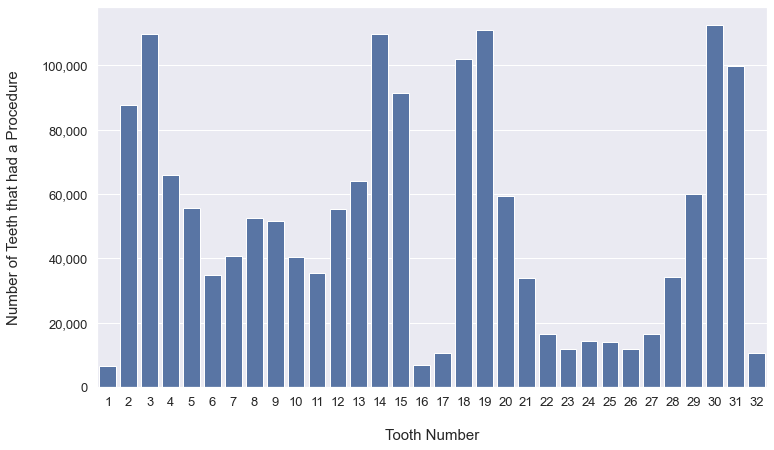

In [341]:
%matplotlib inline

plt.figure(figsize=(12,7))
ax = sns.barplot(x='tooth_num', y='num_teeth',data=tooth_count_df, color='#4c72b0')

ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
# plt.savefig("figures/tooth-count-per-tooth.png", dpi=600, bbox_inches="tight")
plt.show()

## plot total number of distinct teeth by tooth type that underwent a procedure by gender

### join tooth information to gender information

In [342]:
tooth_gender_query = """
select
    tooth_df.patient_id, tooth_num, gender
from
    tooth_df
inner join
    patient_df
on
    tooth_df.patient_id = patient_df.patient_id
order by
    tooth_num
"""
tooth_gender_df = sqldf(tooth_gender_query)

### calculate the number of teeth for each tooth type and gender

In [343]:
tooth_gender_count_query = """
select 
    tooth_num, gender, count(*) as num_teeth
from
    tooth_gender_df
group by
    tooth_num, gender
order by
    tooth_num
"""
tooth_gender_count_df = sqldf(tooth_gender_count_query)

In [344]:
# tooth_gender_count_df.head()

### plot

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


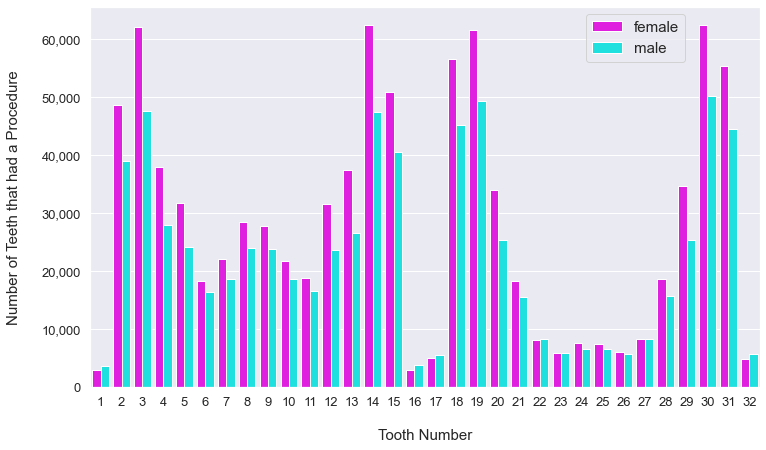

In [345]:
%matplotlib inline
colors = ['magenta', 'cyan']
sns.set_palette(colors)
# sns.set(font_scale=1)

plt.figure(figsize=(12,7))
ax = sns.barplot(x='tooth_num', y='num_teeth', hue="gender",data=tooth_gender_count_df)

ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)
ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
plt.savefig("figures/tooth-count-per-tooth-by-gender.png", dpi=600, bbox_inches="tight")
plt.show()

## create table with tooth number totals for females, males, and all (i.e., males and females)
### this table is helpful for error checking and putting in to paper

In [346]:
## this looks a little hairy, but it only a merger of two queries
## followed by the subset of data we want
## followed by renaming the columns output by the merge
gender_count_table = \
    pds.merge(tooth_gender_count_df.query("gender == 'female'"),
    tooth_gender_count_df.query("gender == 'male'"),
    how='inner',
    on='tooth_num')[['tooth_num', 'num_teeth_x', 'num_teeth_y']].rename(columns={'num_teeth_x': 'female', 'num_teeth_y': 'male'})

In [347]:
# gender_count_table.head()

In [348]:
## merge gender counts with the totals of all teet
all_tooth_count_table = \
    pds.merge(gender_count_table, tooth_count_df, how='inner', on='tooth_num').rename(columns={'num_teeth': 'total'})

In [349]:
all_tooth_count_table.head()

,tooth_num,female,male,total
0,1,2956,3623,6579
1,2,48644,38915,87559
2,3,62118,47690,109808
3,4,37956,27955,65911
4,5,31684,24125,55809


## summarize number of surfaces restored

In [429]:
proc_surface_df.head()

,patient_id,tooth_id,tooth_num,proc_id,m,o,d,b,f,l,i,num_surfaces
0,A_1_1_17,A_1_1_17_7,7,A_1_1_17_7_D2331_2011-04-23,1,0,0,0,0,0,1,2
1,A_1_1_17,A_1_1_17_9,9,A_1_1_17_9_D2335_2006-07-07,1,0,0,0,0,0,1,2
2,A_1_1_17,A_1_1_17_10,10,A_1_1_17_10_D2330_2008-10-12,1,0,0,0,0,0,0,1
3,A_1_1_17,A_1_1_17_10,10,A_1_1_17_10_D2335_2014-03-16,1,0,0,0,1,1,1,4
4,A_1_1_17,A_1_1_17_12,12,A_1_1_17_12_D2392_2012-01-23,0,1,1,0,0,0,0,2


In [460]:
surface_proc_count_query = """
select 
    sum(m) as M,
    sum(o) as O,
    sum(d) as D,
    sum(b) as B,
    sum(f) as F,
    sum(l) as L,
    sum(i) as I
from
    proc_surface_df
"""
surface_proc_count_df = sqldf(surface_proc_count_query)

In [461]:
surface_proc_count_df

,M,O,D,B,F,L,I
0,349291,828424,379688,89869,293911,288138,34517


### melt dataframe for plotting

In [462]:
surface_melt_df = pds.melt(surface_proc_count_df, value_vars=['M', 'O', 'D', 'B', 'F', 'L', 'I'], var_name='surface', value_name='total')

In [463]:
surface_melt_df

,surface,total
0,M,349291
1,O,828424
2,D,379688
3,B,89869
4,F,293911
5,L,288138
6,I,34517


### plot

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
No handles with labels found to put in legend.
/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


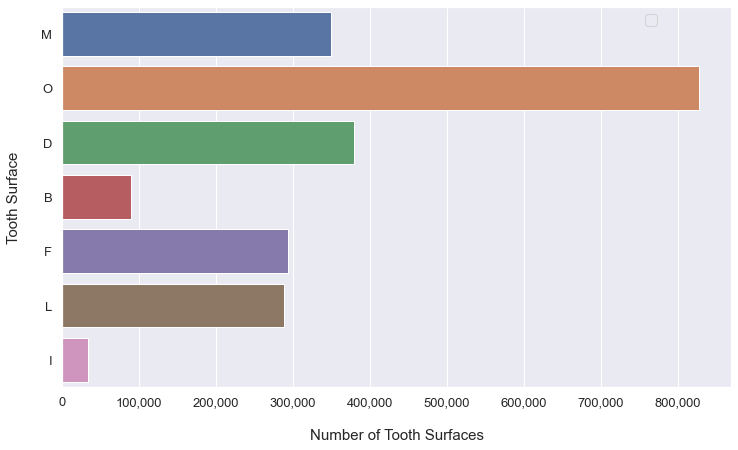

In [465]:
%matplotlib inline
sns.set()

plt.figure(figsize=(12,7))
ax = sns.barplot(x='total', y='surface', data=surface_melt_df)

ax.set_xlabel("\nNumber of Tooth Surfaces", fontsize=15)
ax.set_ylabel("Tooth Surface\n", fontsize=15)

y_ticks = ['M', 'O', 'D', 'B', 'F', 'L', 'I']
ax.set_xticklabels(ax.get_yticks(), size=13)
ax.set_yticklabels(y_ticks, size=13)

ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()]) # put commas in x-ticks

plt.savefig("figures/surfaces-restored-count.png", dpi=600, bbox_inches="tight")
plt.show()

## summarize number of surfaces restored for each tooth type

In [424]:
tooth_surface_proc_count_query = """
select
    case 
        when incisor = 1 then 'incisor'
        when canine = 1 then 'canine'
        when premolar = 1 then 'premolar'
        when molar = 1 then 'molar'
    end as tooth_type,
    case 
        when num_surfaces = 1 then '1 surface'
        when num_surfaces = 2 then '2 surfaces'
        when num_surfaces > 2 then '3+ surfaces'
    end as surface_category,
    count(*) as total
from 
    proc_surface_df
inner join
    tooth_type_df
on 
    proc_surface_df.tooth_id = tooth_type_df.tooth_id
where 
    num_surfaces > 
group by 
    tooth_type, surface_category
order by
    surface_category, tooth_type
"""
tooth_surface_proc_count_df = sqldf(tooth_surface_proc_count_query)

In [425]:
tooth_surface_proc_count_df

,tooth_type,surface_category,total
0,canine,1 surface,39039
1,incisor,1 surface,65657
2,molar,1 surface,305023
3,premolar,1 surface,112548
4,canine,2 surfaces,25326
5,incisor,2 surfaces,60660
6,molar,2 surfaces,242479
7,premolar,2 surfaces,140076
8,canine,3+ surfaces,15874
9,incisor,3+ surfaces,62070


### plot

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


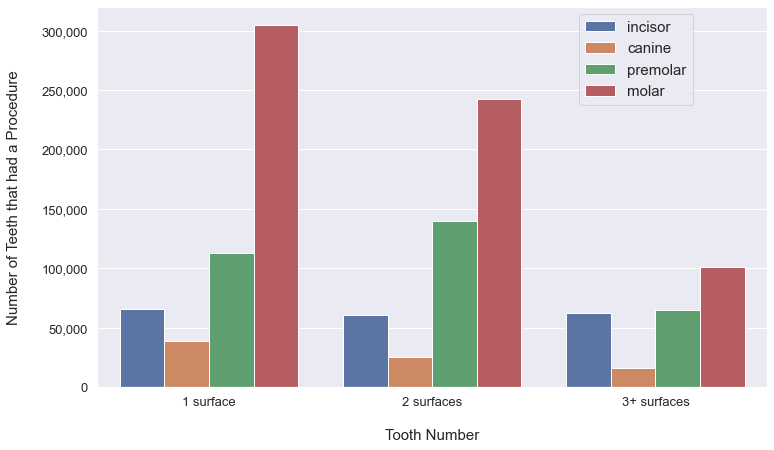

In [466]:
%matplotlib inline
sns.set()

plt.figure(figsize=(12,7))
ax = sns.barplot(x='surface_category', y='total', data=tooth_surface_proc_count_df,
                 hue="tooth_type", hue_order=['incisor', 'canine', 'premolar', 'molar'])

ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)

x_ticks = ['1 surface', '2 surfaces', '3+ surfaces']
ax.set_xticklabels(x_ticks, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)

ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
plt.savefig("figures/surfaces-restored-by-tooth-type-count.png", dpi=600, bbox_inches="tight")
plt.show()

## material figure

In [467]:
proc_material_df.head()

,patient_id,tooth_id,tooth_num,proc_id,restoration_type,material
0,A_1_1_342,A_1_1_342_7,7,A_1_1_342_7_D2740_2013-03-18,crown,porcelain
1,A_1_1_342,A_1_1_342_8,8,A_1_1_342_8_D2740_2013-03-18,crown,porcelain
2,A_1_1_342,A_1_1_342_9,9,A_1_1_342_9_D2740_2013-03-18,crown,porcelain
3,A_1_1_342,A_1_1_342_10,10,A_1_1_342_10_D2740_2013-03-18,crown,porcelain
4,A_1_1_342,A_1_1_342_27,27,A_1_1_342_27_D2740_2014-06-23,crown,porcelain


In [468]:
proc_material_df.material.unique()

array(['porcelain', 'noble metal', 'high noble metal', 'resin', 'amalgam',
       nan, 'ceramic', 'metal', 'predominantly base metal',
       'stainless steel', 'gold foil'], dtype=object)

In [ ]:
proc_material_df[proc_material_df.material]